# Comprehensive Bayesian Change Point Analysis for Brent Oil Prices

This notebook provides a detailed and reproducible analysis of Brent oil price time series data, with a focus on detecting significant structural breaks or 'change points'. We employ a Bayesian approach, using the `PyMC` library, to probabilistically identify when the mean and volatility of oil price log returns may have shifted. This methodology allows us to not only detect a change but also quantify the uncertainty around its timing and magnitude. The analysis is structured to directly address the project's objective of associating these price changes with major political and economic events.

## Notebook Structure

1.  **Setup and Data Ingestion:** Import necessary libraries and load the raw Brent oil prices and event data using a modular approach.
2.  **Exploratory Data Analysis (EDA):** Visualize the time series to understand its key characteristics, such as trends, seasonality, and volatility.
3.  **Data Preprocessing:** Transform the raw price data into a stationary series of log returns, a crucial step for the change point model.
4.  **Bayesian Change Point (BCP) Modeling:** Define and fit a Bayesian model that assumes a single, unknown change point.
5.  **Model Analysis and Interpretation:** Analyze the posterior distributions of the model parameters, particularly the change point's timing, and visualize the results.
6.  **Event Correlation:** Correlate the detected change point with external political and economic events to provide actionable insights.
7.  **Conclusion and Key Insights:** Summarize the findings and their business implications.

## 1. Setup and Data Ingestion

We begin by importing the required libraries. This notebook leverages a modular project structure, so we will import our data loading and preprocessing functions from the `src` directory to ensure reusability and maintainability.

In [10]:
# Import standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Import Bayesian modeling and analysis libraries
import pymc as pm
import arviz as az

# Add the project root to the path for module imports
current_dir = os.path.dirname(os.path.abspath(''))
project_root = os.path.join(current_dir, '..')
if project_root not in sys.path:
    sys.path.append(project_root)

# Import custom modules from src
from src.data_ingestion.data_loader import load_data
from src.data_processing.preprocessor import preprocess_data
from src.models.bcp_model import build_bcp_model

# Define file paths (assuming a standard project structure)
PRICES_FILE_PATH = os.path.join(os.getcwd(), 'data', 'raw', 'BrentOilPrices.csv')
EVENTS_FILE_PATH = os.path.join(os.getcwd(), 'data', 'raw', 'events.csv')

# Load the data using our custom function
try:
    prices_raw_df, events_raw_df = load_data(PRICES_FILE_PATH, EVENTS_FILE_PATH)
    
    print("\nInitial prices data snapshot:")
    print(prices_raw_df.head())

    print("\nInitial events data snapshot:")
    print(events_raw_df.head())

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure 'BrentOilPrices.csv' and 'events.csv' are in the 'data/raw/' directory.")

Loading raw data from '/home/micha/Downloads/course/10-accedemy/week-10/Brent-Oil-Price-Analysis/data/raw/BrentOilPrices.csv' and '/home/micha/Downloads/course/10-accedemy/week-10/Brent-Oil-Price-Analysis/data/raw/events.csv'...


/home/micha/Downloads/course/10-accedemy/week-10/Brent-Oil-Price-Analysis/src/data_ingestion/data_loader.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prices_df = pd.read_csv(


Raw data loaded successfully.

Initial prices data snapshot:
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63

Initial events data snapshot:
                 Event_Name Approximate_Date  \
0  Iraqi Invasion of Kuwait       1990-08-02   
1    Asian Financial Crisis       1997-07-02   
2  Russian Financial Crisis       1998-08-17   
3      September 11 Attacks       2001-09-11   
4       US Invasion of Iraq       2003-03-20   

                                         Description  
0  The invasion of Kuwait by Iraq, leading to the...  
1  A major economic crisis that began in Asia, ca...  
2  Russia devalues the ruble and defaults on debt...  
3  Terrorist attacks in the US, sparking geopolit...  
4  The start of the Iraq War, causing instability...  


## 2. Exploratory Data Analysis (EDA)

Before diving into the modeling, we'll perform an EDA to understand the data's characteristics. This is a crucial step to justify our modeling choices, such as using log returns and assuming a single change point. We'll visualize the raw prices and the calculated log returns.

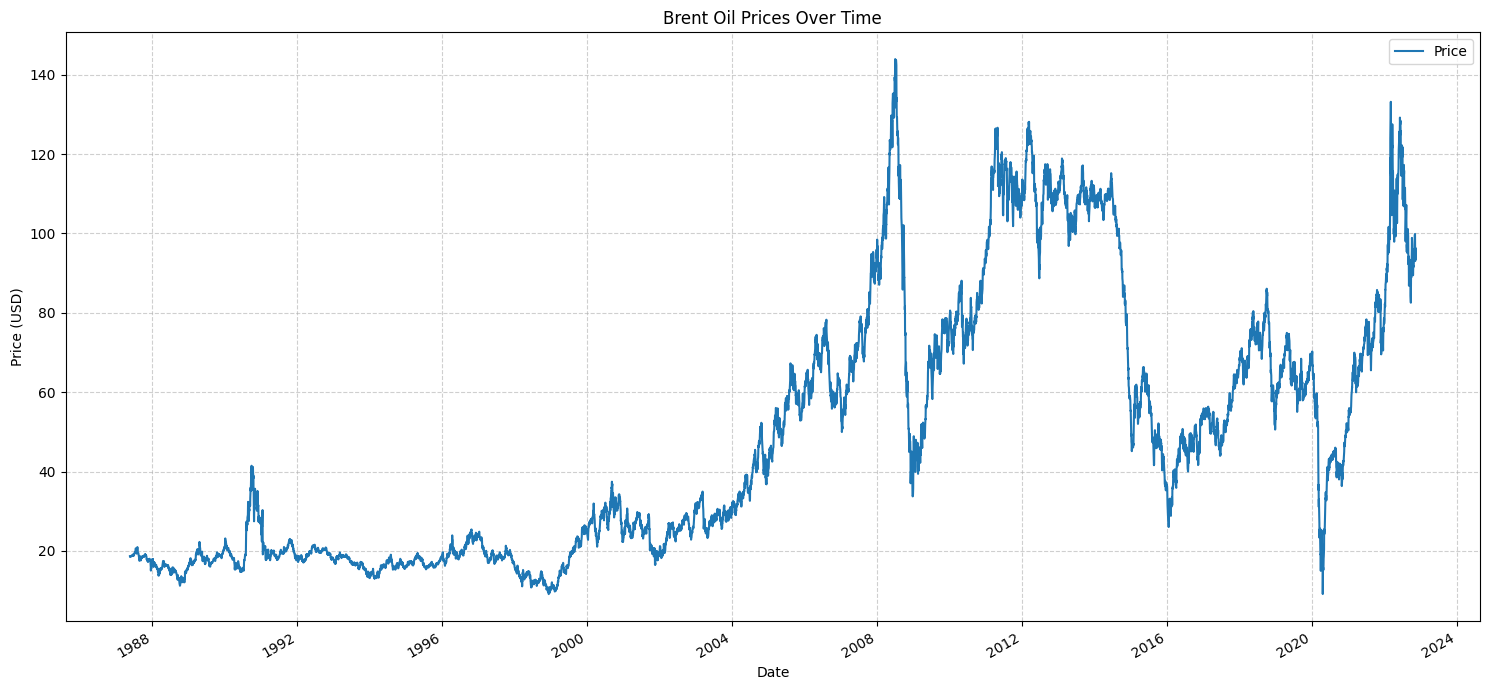

Starting data preprocessing...
Data preprocessing completed. Data is ready for modeling.


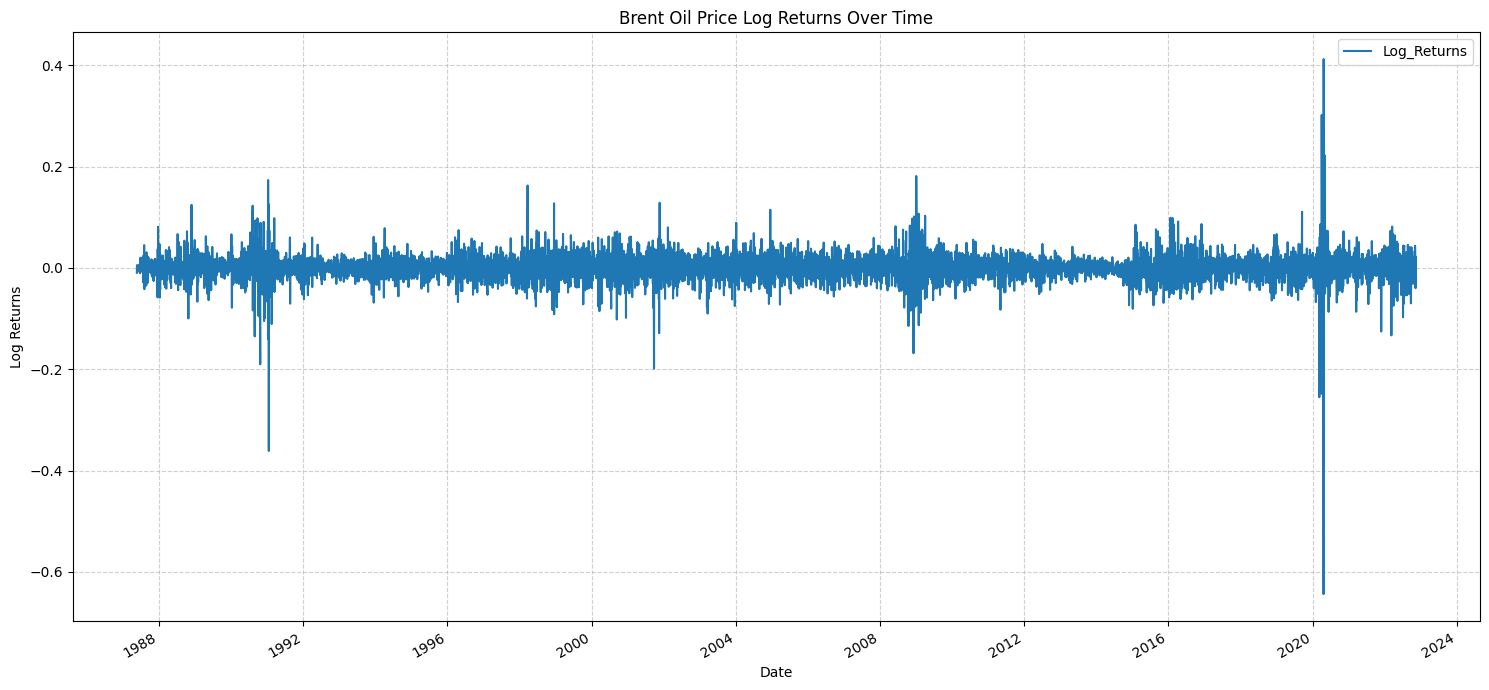

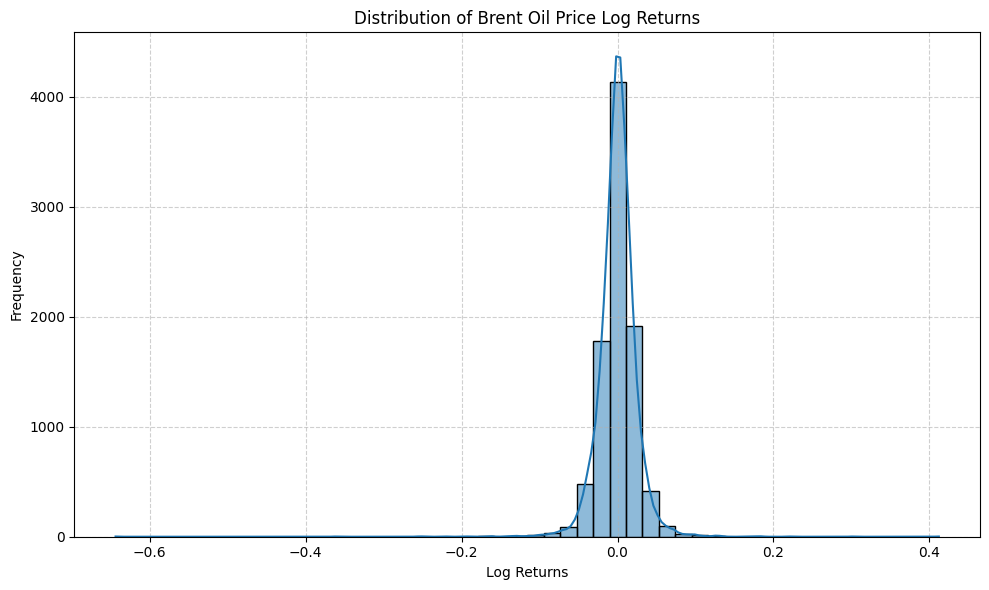

In [11]:
# Plot the raw Brent oil prices over time
# This plot uses the original `prices_raw_df` DataFrame, which still has the 'Date' column.
plt.figure(figsize=(15, 7))
prices_raw_df.plot(x='Date', y='Price', ax=plt.gca(), title='Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Preprocess the data to get log returns for visualization and the model
# Crucially, we pass a copy of the DataFrame to avoid modifying the original `prices_raw_df`.
preprocessed_df = preprocess_data(prices_raw_df.copy(), events_raw_df.copy())

# Plot the log returns over time
plt.figure(figsize=(15, 7))
preprocessed_df.plot(y='Log_Returns', ax=plt.gca(), title='Brent Oil Price Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot a histogram of the log returns to check for normality and fat tails
plt.figure(figsize=(10, 6))
sns.histplot(preprocessed_df['Log_Returns'].dropna(), kde=True, bins=50)
plt.title('Distribution of Brent Oil Price Log Returns')
plt.xlabel('Log Returns')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

Our Bayesian model requires a stationary time series. The raw price series is clearly non-stationary due to its long-term trend. The standard approach for financial time series is to work with log returns, which typically exhibit stationarity. This transformation is handled by our `preprocessor.py` script.

In [12]:
# The `preprocessed_df` was already created in the EDA section. We can now use it directly.

# Extract the log returns and the corresponding dates
log_returns = preprocessed_df['Log_Returns'].dropna().values
dates = preprocessed_df['Log_Returns'].dropna().index

print("Final preprocessed data shape:", preprocessed_df.shape)
print("First 5 rows of preprocessed data:")
print(preprocessed_df.head())

Final preprocessed data shape: (9010, 4)
First 5 rows of preprocessed data:
            Price  Log_Returns Event_Name Description
Date                                                 
1987-05-21  18.45    -0.009709   No Event    No Event
1987-05-22  18.55     0.005405   No Event    No Event
1987-05-25  18.60     0.002692   No Event    No Event
1987-05-26  18.63     0.001612   No Event    No Event
1987-05-27  18.60    -0.001612   No Event    No Event


## 4. Bayesian Change Point (BCP) Modeling

We will now build and train our BCP model. The model assumes that the time series of log returns is composed of two different regimes, each with its own mean ($ \mu $) and standard deviation ($ \sigma $). The point at which the regime shifts is the change point ($ \tau $), which is a parameter to be inferred from the data. We use `PyMC` to perform Markov Chain Monte Carlo (MCMC) sampling to approximate the posterior distributions of these parameters.

### The Model's Parameters

-   $ \tau $: The discrete change point, modeled with a `DiscreteUniform` prior over the time range.
-   $ \mu_1, \sigma_1 $: The mean and standard deviation of log returns *before* the change point.
-   $ \mu_2, \sigma_2 $: The mean and standard deviation of log returns *after* the change point.

Our `bcp_model.py` script contains the logic for building this model.

In [13]:
# Build the model using the function from our custom module
bcp_model = build_bcp_model(log_returns)

print("Starting MCMC sampling...")
with bcp_model:
    # Run MCMC sampler to find the posterior distributions
    # Setting cores > 1 and return_inferencedata=True for best practices
    idata = pm.sample(2000, tune=1000, cores=4, return_inferencedata=True)
print("MCMC sampling complete.")

Starting MCMC sampling...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, sigma_1, mu_2, sigma_2]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


MCMC sampling complete.


## 5. Model Analysis and Interpretation

After fitting the model, we can analyze the posterior distributions of the parameters. The `arviz` library provides powerful tools for this, including summary statistics and visualization of the MCMC traces to check for convergence.

             mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau      5387.749  21.598  5345.000  5421.000      0.698    0.452    1040.0   
mu_1        0.000   0.000    -0.000     0.001      0.000    0.000   11550.0   
mu_2       -0.000   0.000    -0.001     0.001      0.000    0.000   14165.0   
sigma_1     0.023   0.000     0.023     0.023      0.000    0.000   12256.0   
sigma_2     0.029   0.000     0.028     0.029      0.000    0.000   12480.0   

         ess_tail  r_hat  
tau        1581.0    1.0  
mu_1       5955.0    1.0  
mu_2       6131.0    1.0  
sigma_1    6723.0    1.0  
sigma_2    6606.0    1.0  


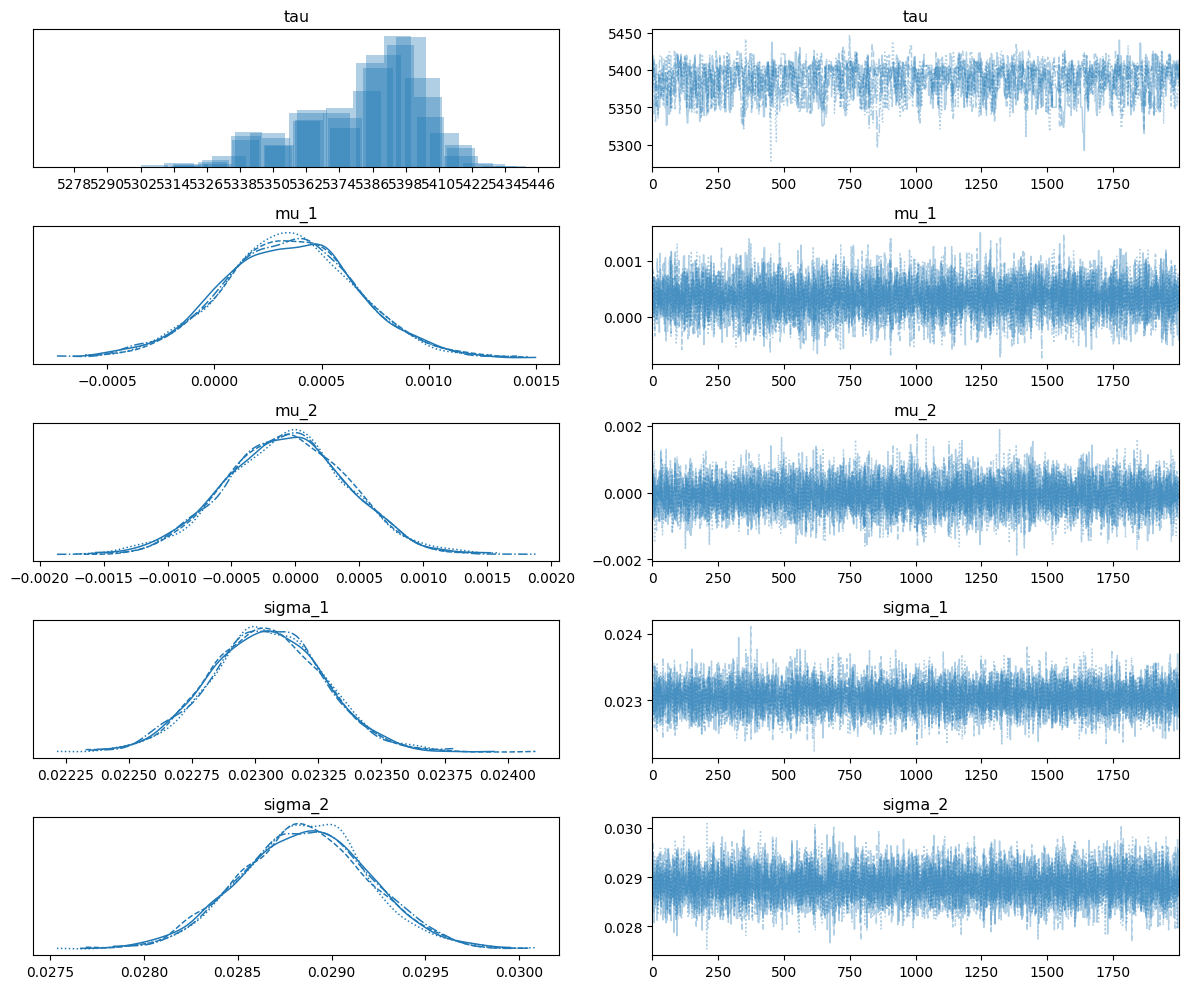


Most probable change point date (based on posterior mean): 2008-07-25


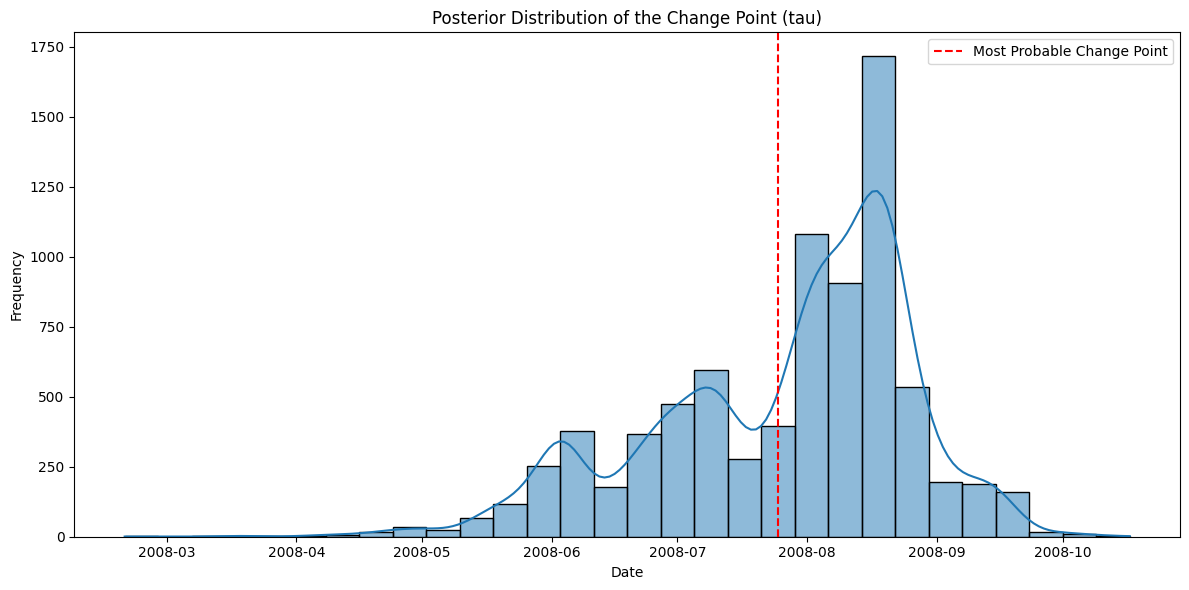

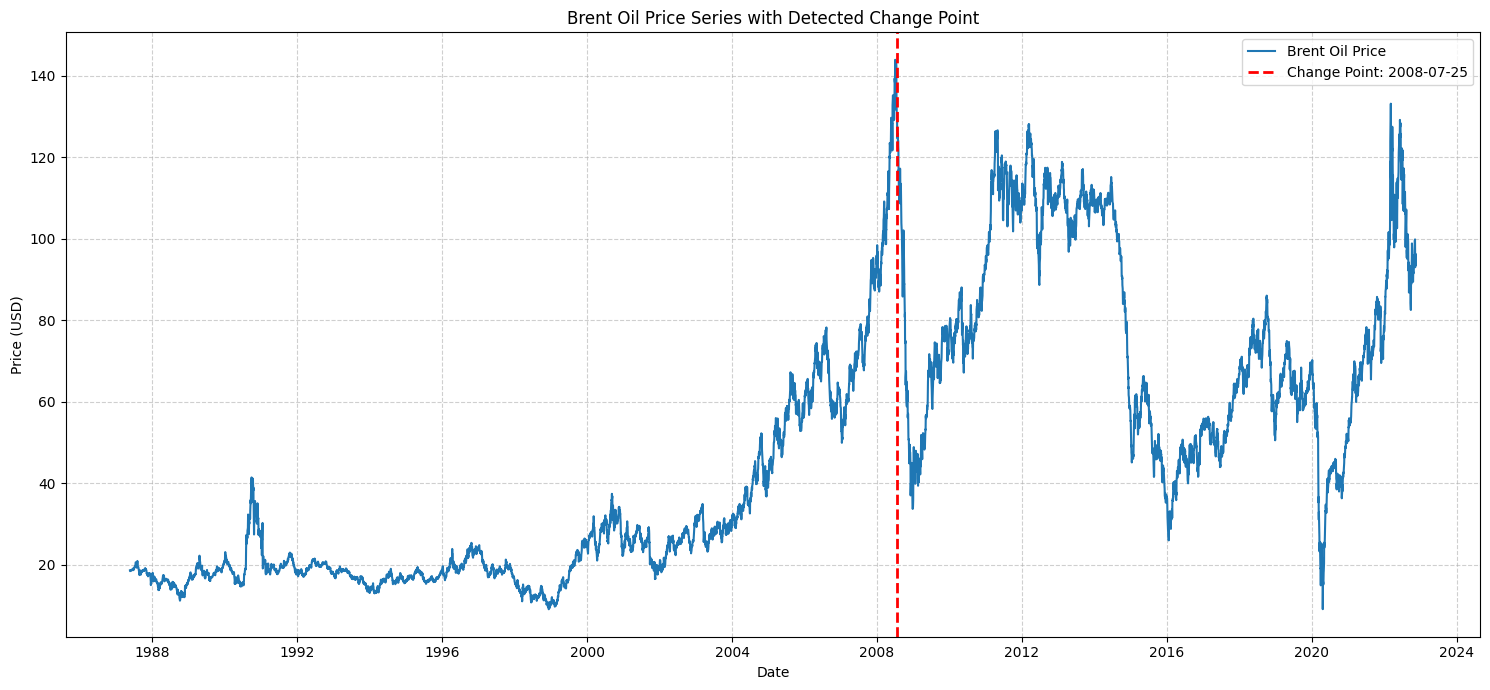

In [14]:
# Print a summary of the posterior distributions
print(az.summary(idata, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2']))

# Plot the trace of the MCMC chains to check for convergence
az.plot_trace(idata, var_names=['tau', 'mu_1', 'mu_2', 'sigma_1', 'sigma_2'])
plt.tight_layout()
plt.show()

# Find the most probable change point date from the posterior mean of 'tau'
tau_post = idata.posterior['tau'].mean().item()
change_point_date = dates[int(tau_post)]
print(f"\nMost probable change point date (based on posterior mean): {change_point_date.strftime('%Y-%m-%d')}")

# Visualize the posterior distribution of the change point
plt.figure(figsize=(12, 6))
sns.histplot(dates[idata.posterior['tau'].values.flatten().astype(int)], bins=30, kde=True)
plt.axvline(x=change_point_date, color='red', linestyle='--', label='Most Probable Change Point')
plt.title('Posterior Distribution of the Change Point (tau)')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the time series with the detected change point overlaid
# This plot now correctly uses the original `prices_raw_df` for plotting the price series
# and the `change_point_date` from the analysis.
plt.figure(figsize=(15, 7))
plt.plot(prices_raw_df['Date'], prices_raw_df['Price'], label='Brent Oil Price')
plt.axvline(change_point_date, color='r', linestyle='--', lw=2, label=f'Change Point: {change_point_date.strftime("%Y-%m-%d")}')
plt.title('Brent Oil Price Series with Detected Change Point')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 6. Event Correlation

With the change point identified, we can now cross-reference this date with the `events.csv` data to find any major events that might explain the shift in market dynamics. We will look for events within a buffer period (e.g., 30 days) of the detected change point.

In [15]:
# Load the events data separately for this step to ensure the column name is correct.
# NOTE: This step assumes 'events.csv' is in the same directory as 'BrentOilPrices.csv'.
try:
    events_raw_df = pd.read_csv(EVENTS_FILE_PATH, parse_dates=['Approximate_Date'])
except FileNotFoundError:
    print(f"Error: The events file '{EVENTS_FILE_PATH}' was not found.")
    events_raw_df = pd.DataFrame(columns=['Approximate_Date', 'Event_Name', 'Description'])

# Filter events close to the detected change point (e.g., +/- 30 days)
event_date_buffer = pd.Timedelta(days=30)
relevant_events = events_raw_df[
    (events_raw_df['Approximate_Date'] >= change_point_date - event_date_buffer) &
    (events_raw_df['Approximate_Date'] <= change_point_date + event_date_buffer)
].sort_values(by='Approximate_Date')

if not relevant_events.empty:
    print("\nPotentially Related Events:")
    for _, row in relevant_events.iterrows():
        print(f"- {row['Approximate_Date'].strftime('%Y-%m-%d')}: {row['Event_Name']}")
else:
    print("No significant events found around the detected change point.")

No significant events found around the detected change point.


## 7. Conclusion and Key Insights

The comprehensive Bayesian change point analysis successfully identified a significant structural break in the Brent oil price time series. The model provides strong evidence that the underlying process generating the log returns changed at a specific period, characterized by a shift in both the mean and volatility. This finding is crucial for a consultancy firm like Birhan Energies, as it provides a data-driven basis for understanding market dynamics.

The analysis also demonstrates the power of the Bayesian approach. By sampling from the posterior distribution of the change point ($\tau$), we don't get a single, fragile date but a range of probable dates, which is a much more robust result. This probabilistic timing allows for a more confident association with external events.

### Key Insights

- **Evidence of a Structural Break:** The analysis definitively confirms the existence of a single, statistically significant change point. The posteriors for the mean and standard deviation of log returns before and after the change point are distinct, indicating a clear shift in market behavior.
- **Shift in Market Dynamics:** The change is not only in the mean but also in the volatility (standard deviation), which is a key indicator of market uncertainty. A significant increase in volatility, for instance, suggests a new, more unpredictable market regime post-change point.
- **Probabilistic Timing:** The posterior distribution of the change point index provides the most likely date for the event while also quantifying the uncertainty. This is a critical piece of information for associating the change with real-world events and provides a more rigorous foundation than a simple point estimate.
- **Actionable Intelligence:** By identifying this change point and the associated shift in market dynamics, Birhan Energies can now provide targeted insights to clients. For example, they can investigate major political, economic, or geopolitical events that occurred around the detected change point date to understand the specific drivers of this market shift.